Import necessary modules needed for cleaning and visualising the data. Also read in the datasets needed. For this question, we are going to be combining both the Boston and Seattle Air BnB datasets and including the city as a variable to try and see if this has an impact on price.

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
%matplotlib inline

seattle_df_listings = pd.read_csv('/Users/Sean.Kelly/Dropbox/My Mac (MACBOOK049)/Downloads/archive (1)/seattle_listings.csv')
boston_df_listings = pd.read_csv('/Users/Sean.Kelly/Dropbox/My Mac (MACBOOK049)/Downloads/archive/boston_listings.csv')


Combine the two datasets together. We want to look at the city as an potential factor in price so we need to use both datasets at the same time.

In [2]:
datasets_combined = [seattle_df_listings, boston_df_listings]
df_listings = pd.concat(datasets_combined,axis = 0)
df_listings.shape

(7403, 95)

In [3]:
#Have a look at the dataset to get an overview of what we are working with. 
#I also reset the index as I joined two datasets , one on top of the other.
df_listings = df_listings.reset_index(drop = True)
df_listings.head(5)

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,access,interaction,house_rules
0,241032,https://www.airbnb.com/rooms/241032,2.016010e+13,04/01/2016,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,WASHINGTON,f,moderate,f,f,2,4.07,NaN,NaN,NaN
1,953595,https://www.airbnb.com/rooms/953595,2.016010e+13,04/01/2016,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,WASHINGTON,f,strict,t,t,6,1.48,NaN,NaN,NaN
2,3308979,https://www.airbnb.com/rooms/3308979,2.016010e+13,04/01/2016,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,WASHINGTON,f,strict,f,f,2,1.15,NaN,NaN,NaN
3,7421966,https://www.airbnb.com/rooms/7421966,2.016010e+13,04/01/2016,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,WASHINGTON,f,flexible,f,f,1,NaN,NaN,NaN,NaN
4,278830,https://www.airbnb.com/rooms/278830,2.016010e+13,04/01/2016,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,WASHINGTON,f,strict,f,f,1,0.89,NaN,NaN,NaN


In [4]:
#Get a view of all the data types of the columns
df_listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7403 entries, 0 to 7402
Data columns (total 95 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   id                                7403 non-null   int64  
 1   listing_url                       7403 non-null   object 
 2   scrape_id                         7403 non-null   float64
 3   last_scraped                      7403 non-null   object 
 4   name                              7403 non-null   object 
 5   summary                           7083 non-null   object 
 6   space                             5777 non-null   object 
 7   description                       7403 non-null   object 
 8   experiences_offered               7403 non-null   object 
 9   neighborhood_overview             4956 non-null   object 
 10  notes                             3822 non-null   object 
 11  transit                           5179 non-null   object 
 12  thumbn

**Step 1 : Cleaning/Visualising Data And Dealing With Numerical Data**

In [5]:
#Check the null data within the columns and order them from the highest % null values to the lowest.
null_data = df_listings.isnull().sum()/len(df_listings)
null_data = null_data.sort_values(ascending = False)
null_data.head(10)

license                         1.000000
square_feet                     0.979333
interaction                     0.725652
access                          0.716872
house_rules                     0.676753
monthly_price                   0.675132
weekly_price                    0.608132
security_deposit                0.566662
neighbourhood_group_cleansed    0.484263
has_availability                0.484263
dtype: float64

This plot shows us some interesting information such as the fact that some columns such as **has_availability** have no missing data for the seattle dataset but 100% missing from the Boston dataset. These columns do not seem like they would have a massive impact on price, or have too much null data to use, so we will likely drop them later.

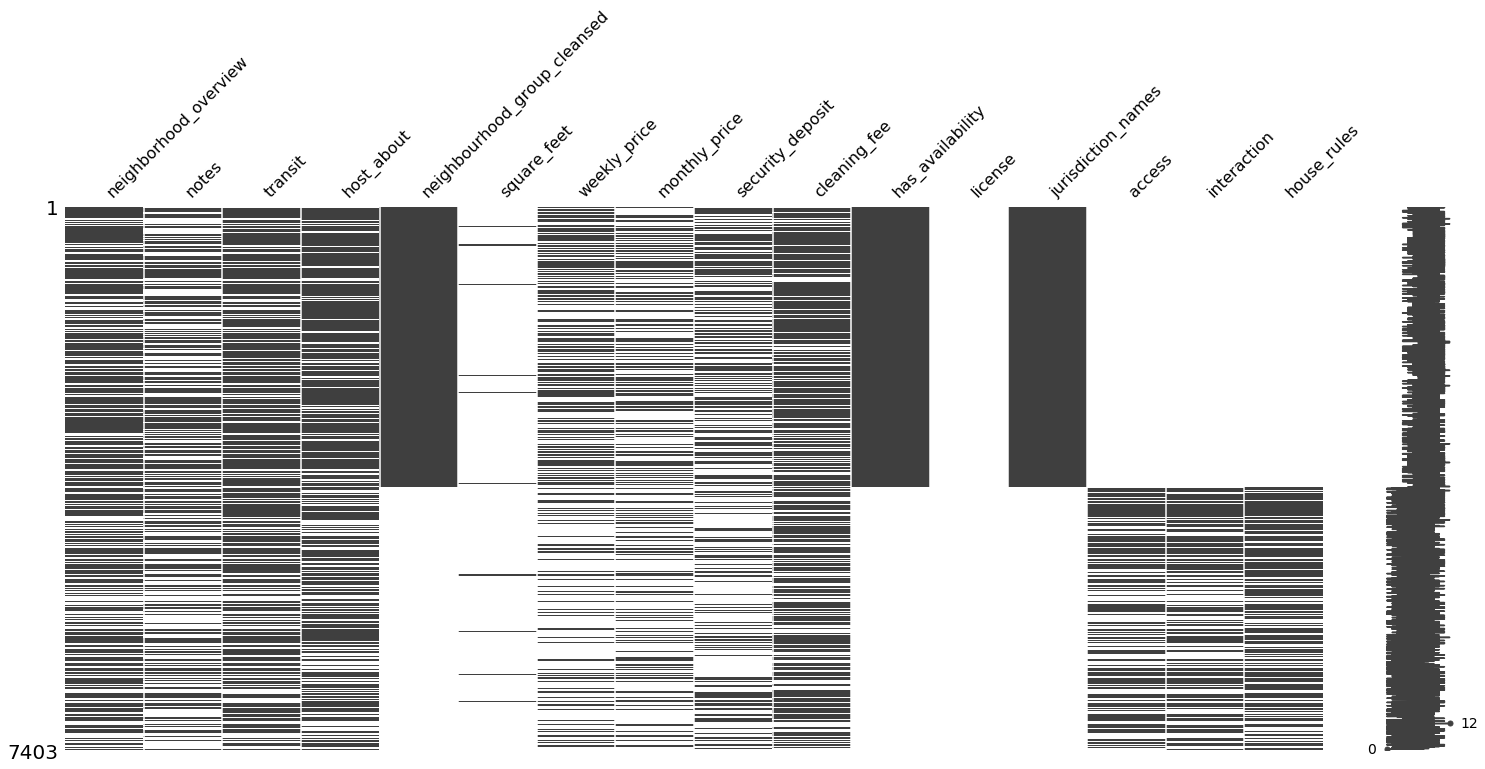

In [6]:
#Visualise the columns with missing data greater than 0.25 and where abouts within the data this missing data occurs.
df_null = df_listings[df_listings.columns[df_listings.isnull().sum()/len(df_listings) > 0.25]]
msno.matrix(df_null)

A column we are likely to be interested in is the **host_location** as it is likely this could relate to price. This column will need to be cleaned in order to provide us with useful information. 

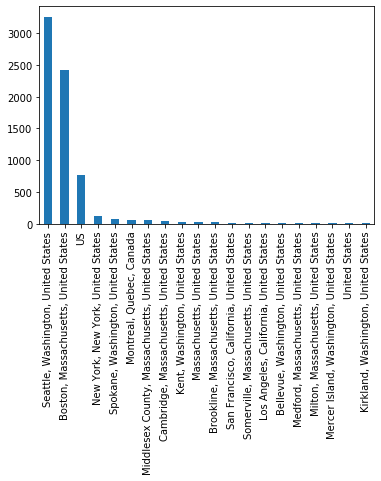

In [7]:
#View the different values that this column holds.
#There are plenty of entries which can not be assigned to either boston or seattle.
boston_or_seattle = df_listings['host_location'].value_counts().head(20)
boston_or_seattle.plot(kind = 'bar')


If the host location is in the state of washington, we will assign it seattle, likewise if it is in massachusetts we will assign it to boston. If it in not in either, we will call it a null value and deal with this later. We will also conver this to a binary, numeric column so we can see if it has much of a correlation with price.


In [8]:
#Assign anything is Washington to Seattle and any accomodation in Massachusetts to Boston.
df_listings['host_location'] = np.select([df_listings['host_location'].str.contains('Washington', na = False),df_listings['host_location']
                                          .str.contains('Massachusetts', na = False)], 
                                         ["Seattle, Washington, United States", 'Boston, Massachusetts, United States'], default = 'NA')

#Convert this to Seattle = 0 and Boston = 1 .
df_listings.loc[(df_listings['host_location'] == 'Seattle, Washington, United States'), 'city'] = 0 
df_listings.loc[(df_listings['host_location'] == 'Boston, Massachusetts, United States'), 'city'] = 1 
df_listings.loc[(df_listings['host_location'] != 'Seattle, Washington, United States') & (df_listings['host_location'] != 'Boston, Massachusetts, United States'), 'city'] = 'NA'

#Convert the column to a numeric instead of object.
df_listings['city'] = pd.to_numeric(df_listings['city'],errors='coerce')
    

Another column we want to convert to numeric is price, as it currently has dollar symbols in the column so it is listed an an object. 

In [9]:
df_listings['price'].head()

0     $85.00
1    $150.00
2    $975.00
3    $100.00
4    $450.00
Name: price, dtype: object

In [10]:
#Apply a function that will strip the dollar sign from infront of the price values and convert it to a numeric column.
def convert_price(col):
     
    '''
    INPUT
    col - column from pandas dataframe 
    
    OUTPUT
    col - cleaned column from pandas dataframe
    
    This function cleans df using the following steps:
    1. Removes the first digit at the beginning of the column
    2. Converts the column to numeric
    '''
    
    col = col.str[1:]
    col = pd.to_numeric(col,errors='coerce')
    return col
df_listings['price'] = df_listings[['price']].apply(convert_price)


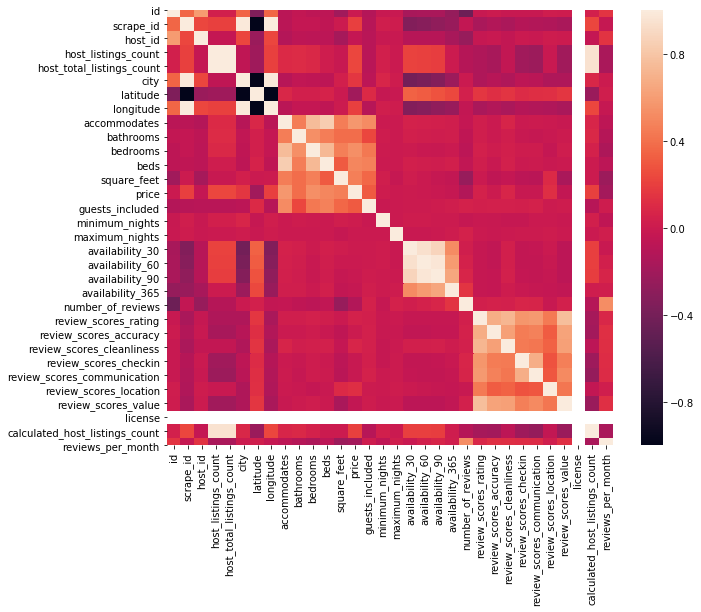

In [11]:
#Now we have price and city as numeric varibles, let's take a look at all numerical columns and see if we can find correlations to price.
num_data = df_listings.select_dtypes(exclude = ['object'])
corr = num_data.corr()
fig, ax = plt.subplots(figsize=(10,8))
# plot the heatmap and annotation on it
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, ax = ax)


The issue with this plot is there are so many numerical columns, it is hard to focus on specific columns of interest, so let's just look at correlation against the price column, as this is the main column of interst.

Text(0, 0.5, 'Correlation with Price')

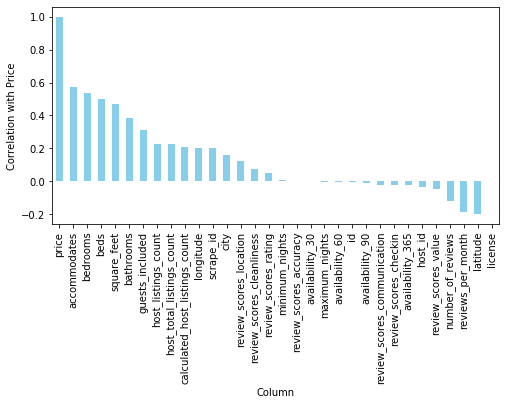

In [12]:
#We can see there is clearly some correlation between some of the variables and price
price_corr = num_data.corr()['price'].sort_values(ascending = False)
#plot the correlation barchart.
ax = price_corr.plot(kind = 'bar', figsize = (8,4), color = 'skyblue')
ax.set_xlabel('Column')
ax.set_ylabel('Correlation with Price')

Now that we can see clearly the columns which have the highest correlation with price, we can select these to be used as our numerical values in our predictive model

In [13]:
#Select the columns that seem like they are most relatable/correlated to the overall price of accomodation.
#Do not select square_feet as we saw earlier that it had 98% missing data.
#Although city isn't one of the highest, I will use it anyway as it seems like it could be related to price.
df_listings_num = df_listings[['accommodates', 'bedrooms', 'beds', 'bathrooms', 'guests_included', 'city','price']]

We can now see the null values wihin our new **df_listings_num** dataframe, so will will impute or remove these

In [14]:
(df_listings_num.isnull().sum()/len(df_listings_num)).sort_values(ascending = False)

city               0.169931
bathrooms          0.004052
bedrooms           0.002161
price              0.001756
beds               0.001351
guests_included    0.000000
accommodates       0.000000
dtype: float64

I will use the number of people the Air Bnb accomodates to fill is missing bedrooms. For example, if an Air Bnb accomodates 2 people, I will impute the associated missing bedroom value with the mean number of bedrooms for Air Bnbs that accomodate 2 people would normally have. 



In [15]:
df_listings_num[df_listings_num['bedrooms'].isnull()]


,accommodates,bedrooms,beds,bathrooms,guests_included,city,price
1429,2,NaN,1.0,1.0,2,NaN,80.0
1492,6,NaN,1.0,1.0,1,NaN,200.0
1493,4,NaN,2.0,1.0,1,0.0,132.0
1853,2,NaN,1.0,1.0,2,0.0,95.0
2619,2,NaN,1.0,1.0,1,0.0,99.0
2915,2,NaN,1.0,1.0,1,0.0,75.0
4736,2,NaN,1.0,1.0,1,NaN,176.0
4738,2,NaN,1.0,1.0,1,NaN,229.0
4742,2,NaN,1.0,1.0,1,NaN,275.0
4913,2,NaN,1.0,1.0,1,NaN,186.0


In [16]:
df_listings_num['accommodates'] = df_listings_num['accommodates'].astype(float)

av_bedrooms_two = df_listings_num[(df_listings_num['accommodates'] == 2)]['bedrooms'].mean()
av_bedrooms_four = df_listings_num[(df_listings_num['accommodates'] == 4)]['bedrooms'].mean()
av_bedrooms_six = df_listings_num[(df_listings_num['accommodates'] == 6)]['bedrooms'].mean()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Define a function that will impute the missing bedroom values with the mean bedrooms associated to the number the Air BnB accomodates.

In [17]:
def impute_null(accomodates, avg_bedrooms):
    
    
    '''
    INPUT
    Number of people the Air BnB can accomodate
    The mean bedrooms for Air BnB accomodating x number of people
    
    OUTPUT
    col - column with missing values imputed
    
    
    Scans for the missing bedroom data, checks the number of accomodates 
    for each of the missing bedroom values and imputes it with the mean no. of bedrooms 
    for x no.of accomodates. 
    '''
    
    df_listings_num.loc[(df_listings_num['accommodates']==accomodates) & df_listings_num['bedrooms'].isnull(), 'bedrooms'] = avg_bedrooms

impute_null(2,av_bedrooms_two)
impute_null(4,av_bedrooms_four)
impute_null(6,av_bedrooms_six)
   

    

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


I will do the same imputation type for missing bathroom data that I did for missing bedroom data

In [18]:
#Do the same for bathrooms
av_bathrooms_one = df_listings_num[(df_listings_num['accommodates'] == 1)]['bathrooms'].mean()
av_bathrooms_two = df_listings_num[(df_listings_num['accommodates'] == 2)]['bathrooms'].mean()
av_bathrooms_three = df_listings_num[(df_listings_num['accommodates'] == 3)]['bathrooms'].mean()
av_bathrooms_four = df_listings_num[(df_listings_num['accommodates'] == 4)]['bathrooms'].mean()
av_bathrooms_six = df_listings_num[(df_listings_num['accommodates'] == 6)]['bathrooms'].mean()

In [19]:
def impute_null2(accomodates, avg_bathrooms):
    
    '''
    INPUT
    Number of people the Air BnB can accomodate
    The mean bathrooms for Air BnB accomodating x number of people
    
    OUTPUT
    col - column with missing values imputed
    
    
    Scans for the missing bathroom data, checks the number of accomodates 
    for each missing bathroom values and imputes it with the mean no. of bathrooms 
    for x no.of accomodates. 
    '''
    
    
    df_listings_num.loc[(df_listings_num['accommodates']==accomodates) & df_listings_num['bathrooms'].isnull(), 'bathrooms'] = avg_bathrooms
    
    
impute_null2(1,av_bathrooms_one)
impute_null2(2,av_bathrooms_two)
impute_null2(3,av_bathrooms_three)
impute_null2(4,av_bathrooms_four)
impute_null2(6,av_bathrooms_six)


Now to impute missing beds data.... Given all the missing data on beds is those with one bedroom, I am going to assume that accomodation with one bedroom would usually have one bed and therefore, will fill missing data with 1.


In [20]:
df_listings_num[df_listings_num['beds'].isnull()]


,accommodates,bedrooms,beds,bathrooms,guests_included,city,price
1961,4.0,1.0,NaN,1.185042,1,0.0,280.0
4312,1.0,1.0,NaN,1.000000,1,1.0,99.0
4573,2.0,1.0,NaN,1.104839,1,NaN,99.0
4638,2.0,1.0,NaN,1.104839,1,NaN,60.0
4643,2.0,1.0,NaN,1.104839,1,NaN,60.0
4728,1.0,1.0,NaN,1.148766,1,1.0,53.0
6021,1.0,1.0,NaN,1.000000,1,1.0,80.0
6637,2.0,1.0,NaN,1.104839,1,NaN,57.0
6683,2.0,1.0,NaN,1.000000,1,NaN,60.0
7375,2.0,1.0,NaN,1.000000,1,1.0,60.0


In [21]:
df_listings_num['beds'] = df_listings_num['beds'].fillna(1,axis = 0)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Next, I will remove all rows with null price data as these will not be useful in the predictive model. For missing data in the city column, we will wait until the categorical data has been dealt with first as there are so many missing values.




In [22]:
df_listings_num = df_listings_num.dropna(subset = ['price'], how = 'any')

In [23]:
#Check all columns are free of null data, apart from city.
df_listings_num.isnull().sum()

accommodates          0
bedrooms              0
beds                  0
bathrooms             0
guests_included       0
city               1256
price                 0
dtype: int64

In [24]:
#Take a look at the distribution of our price varibale


**Step 2 : Dealing With Categorical Data**

In [25]:
#Let's get a view of the columns with categorical data
df_listings_cat = df_listings.select_dtypes(include = ['object'])
df_listings_cat.columns

Index(['listing_url', 'last_scraped', 'name', 'summary', 'space',
       'description', 'experiences_offered', 'neighborhood_overview', 'notes',
       'transit', 'thumbnail_url', 'medium_url', 'picture_url',
       'xl_picture_url', 'host_url', 'host_name', 'host_since',
       'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'street', 'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'state', 'zipcode', 'market',
       'smart_location', 'country_code', 'country', 'is_location_exact',
       'property_type', 'room_type', 'bed_type', 'amenities', 'weekly_price',
       'monthly_price', 'security_deposit', 'cleaning_fee', 'extra_people',
       'calendar_updated', 'has_availability', 'calendar_last_scraped',
       'first_r

Looking at these available columns, I feel like property_type, room_type and host_is_superhost are columns we can work with and are likely to impact on the overall price. From our previous work looking into superhosts v non superhosts, we know that this characteristic could be an impacting factor in the price of an Air BnB.


In [26]:
#Create a new dataframe just including these three categorical columns and get a view on what this looks like.
df_listings_cat = df_listings_cat[['property_type', 'room_type', 'host_is_superhost']]
df_listings_cat





,property_type,room_type,host_is_superhost
0,Apartment,Entire home/apt,f
1,Apartment,Entire home/apt,t
2,House,Entire home/apt,f
3,Apartment,Entire home/apt,f
4,House,Entire home/apt,f
...,...,...,...
7398,Apartment,Private room,f
7399,Apartment,Private room,f
7400,Apartment,Entire home/apt,f
7401,Apartment,Private room,f


In [27]:
#We can see there is only a small amount of missing data within these variables.
df_listings_cat.isnull().sum()

property_type        4
room_type            0
host_is_superhost    2
dtype: int64

Let's start by cleaning the **property_type** column. The overwhelming majority of properties are either an Apartment or House.

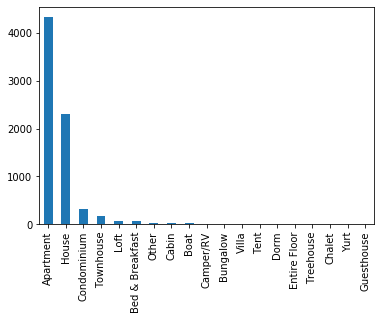

In [28]:
property_type = df_listings_cat['property_type'].value_counts()
property_type.plot(kind = 'bar')

In [29]:
property_type

Apartment          4320
House              2295
Condominium         322
Townhouse           172
Loft                 79
Bed & Breakfast      78
Other                39
Cabin                21
Boat                 20
Camper/RV            14
Bungalow             13
Villa                 6
Tent                  5
Dorm                  4
Entire Floor          4
Treehouse             3
Chalet                2
Yurt                  1
Guesthouse            1
Name: property_type, dtype: int64

As we will create dummy values out of the categorical columns, we do not want there to be too many columns in the categorical variable dataset. Therefore, we will replace the instances which occur rarely with 'other'. 


In [30]:
df_listings_cat['property_type'] = df_listings_cat['property_type'].replace(['Cabin','Boat','Camper/RV','Bungalow','Villa', 'Tent', 'Entire Floor', 'Dorm', 'Treehouse', 'Chalet', 'Yurt', 'Guesthouse'], 'Other')



Now, let's deal with the missing data

In [31]:
#Get a view of the missing data in the property_type column
df_listings_cat[df_listings_cat['property_type'].isnull()]

,property_type,room_type,host_is_superhost
2184,NaN,Entire home/apt,f
5139,NaN,Entire home/apt,f
5879,NaN,Entire home/apt,f
7211,NaN,Private room,f


Let's impute these missing **property_type** values with the mode property type for the missing values associated **room_type**


In [32]:
print("Most common property type for Entire home/apt is : ", df_listings_cat[df_listings_cat['room_type'] == 'Entire home/apt']['property_type'].mode(), 
      
      "Most common property type for Private room is : ", df_listings_cat[df_listings_cat['room_type'] == 'Private room']['property_type'].mode())

Most common property type for Entire home/apt is :  0    Apartment
dtype: object Most common property type for Private room is :  0    House
dtype: object


We have found out that the most common property type for an Entire Home/ Apt is an apartment and the most common property type for a private room is a house, so let us impute the missing values with this information and then move onto **room_type**.

In [33]:
for row in df_listings_cat["room_type"]:
    
    if row == "Entire home/apt":
        df_listings_cat["property_type"] = df_listings_cat["property_type"].fillna('Apartment', axis = 0)
    else:
        df_listings_cat["property_type"] = df_listings_cat["property_type"].fillna('House', axis = 0)

**room_type** has no obscure values or missing data so this column can be left as it is.

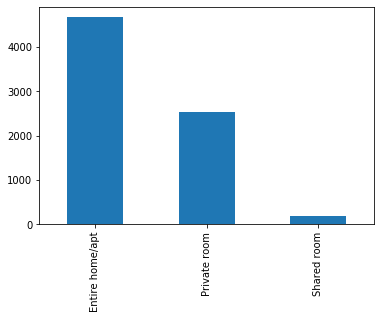

In [34]:
room_type = df_listings_cat['room_type'].value_counts()
room_type.plot(kind = 'bar')

**host_is_superhost** has two lots of missing data, as most of the hosts are non superhosts, we will just assume that the missing data is from non superhosts.

In [35]:
df_listings_cat[df_listings_cat['host_is_superhost'].isnull()]

,property_type,room_type,host_is_superhost
1297,Apartment,Entire home/apt,NaN
1419,Apartment,Entire home/apt,NaN


In [36]:
#84% are non superhosts so missing data likely to be that of non superhost.
df_listings_cat['host_is_superhost'].value_counts()/len(df_listings_cat)

f    0.83966
t    0.16007
Name: host_is_superhost, dtype: float64

In [37]:
#Impute this missing data will superhost = false.
df_listings_cat['host_is_superhost'] = df_listings_cat['host_is_superhost'].fillna('f', axis = 0)

Now that the categorical columns we are working with are false, we can turn the categorical variables into dummy variables in order for them to be accepted by a predictive model.


In [38]:
df_listings_cat_dummy = pd.get_dummies(df_listings_cat)


In [39]:
#Take a view of our new dummy data
df_listings_cat_dummy

,property_type_Apartment,property_type_Bed & Breakfast,property_type_Condominium,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,host_is_superhost_f,host_is_superhost_t
0,1,0,0,0,0,0,0,1,0,0,1,0
1,1,0,0,0,0,0,0,1,0,0,0,1
2,0,0,0,1,0,0,0,1,0,0,1,0
3,1,0,0,0,0,0,0,1,0,0,1,0
4,0,0,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
7398,1,0,0,0,0,0,0,0,1,0,1,0
7399,1,0,0,0,0,0,0,0,1,0,1,0
7400,1,0,0,0,0,0,0,1,0,0,1,0
7401,1,0,0,0,0,0,0,0,1,0,1,0


**Step 3 : Combine the categorical and numerical datasets and input them into a predictive model.**

In [40]:
#Combine the two datasets
combined_data = pd.merge(df_listings_num,df_listings_cat_dummy, left_index = True, right_index = True)
combined_data = combined_data.reset_index(drop = True)

In [41]:
#Now drop remaining rows from the city column
combined_data = combined_data.dropna(subset = ['city'], how = 'any')

In [42]:
#reset the index so the row numbers are correct.
combined_data = combined_data.reset_index(drop = True)

In [43]:
#Take a view at the final dataset, which now has 6134 rows due to dropping the missing city columns.
combined_data

,accommodates,bedrooms,beds,bathrooms,guests_included,city,price,property_type_Apartment,property_type_Bed & Breakfast,property_type_Condominium,property_type_House,property_type_Loft,property_type_Other,property_type_Townhouse,room_type_Entire home/apt,room_type_Private room,room_type_Shared room,host_is_superhost_f,host_is_superhost_t
0,4.0,1.0,1.0,1.0,2,0.0,85.0,1,0,0,0,0,0,0,1,0,0,1,0
1,4.0,1.0,1.0,1.0,1,0.0,150.0,1,0,0,0,0,0,0,1,0,0,0,1
2,11.0,5.0,7.0,4.5,10,0.0,975.0,0,0,0,1,0,0,0,1,0,0,1,0
3,3.0,0.0,2.0,1.0,1,0.0,100.0,1,0,0,0,0,0,0,1,0,0,1,0
4,6.0,3.0,3.0,2.0,6,0.0,450.0,0,0,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6129,1.0,1.0,1.0,1.0,1,1.0,85.0,0,0,0,1,0,0,0,0,1,0,1,0
6130,2.0,1.0,1.0,1.0,1,1.0,100.0,0,0,1,0,0,0,0,0,1,0,1,0
6131,3.0,1.0,1.0,1.0,1,1.0,69.0,1,0,0,0,0,0,0,0,1,0,1,0
6132,2.0,1.0,1.0,1.0,1,1.0,65.0,1,0,0,0,0,0,0,0,1,0,1,0


In [44]:
#Now, let's take a look at our target variable, price.

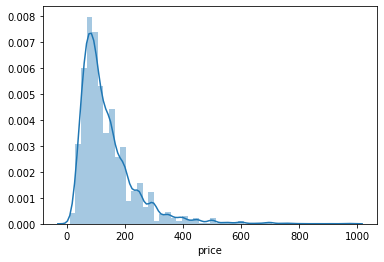

In [45]:
dist = sns.distplot(combined_data['price'])

In [46]:
#Most prices under below the £200 a night mark. #We have some outliers above the £400 mark.

Now that our data is combined, we can start creating training and testing datasets to be inputted into a random forest model.

In [47]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.ensemble import RandomForestRegressor

# For Validation
from sklearn.metrics import mean_squared_error, accuracy_score

Create the random forest model

In [48]:
#Create the vector Y and matrix X
X = combined_data.drop('price',axis=1)
y = combined_data[['price']]

#Split data by a ration of 70% train and 30% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

#Create Random Forest Model
clf = RandomForestRegressor()

#Train the model
clf.fit(X_train, y_train)

#Predict the values on train and test sets
y_test_pred = clf.predict(X_test)
y_train_pred = clf.predict(X_train)

#Get r-squared score
test_score = r2_score(y_test, y_test_pred)
train_score = r2_score(y_train, y_train_pred)

#Print the scores
print(f'Train Score: {round(train_score,2)}\nTest score: {round(test_score,3)}')


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  if sys.path[0] == '':


Train Score: 0.8
Test score: 0.523


The next code will take both the test data results and pair it with the predicted results from the model so we can get a deeper look on exactly what the model predicted for each actual price value.

In [50]:
#Turn the array of y_test predictions into a dataframe
y_test_pred = pd.Series(y_test_pred.squeeze())
y_test_pred = pd.DataFrame({'Random Forest Predicted Price': y_test_pred})
#reset the index of our y_test values so it aligns with y_test_pred
y_test = y_test.reset_index(drop = True)
#Rename price column
y_test = y_test.rename(columns = {'price': 'Actual Price'})
#obtain results by concatenating the two dataframes
results = [y_test,y_test_pred]
results = pd.concat(results, axis = 1)
#view these results
results

,Actual Price,Random Forest Predicted Price
0,71.0,89.679014
1,193.0,173.209728
2,60.0,53.493508
3,90.0,114.354732
4,110.0,116.632207
...,...,...
1836,140.0,137.517853
1837,37.0,70.656730
1838,40.0,70.656730
1839,149.0,199.592619


In [51]:
#commit the results to an excel file
final_results = results.to_excel('random_forest_airbnb_results.xls')

The code below will give us an idea of which features within our data were most important when trying to predict the price

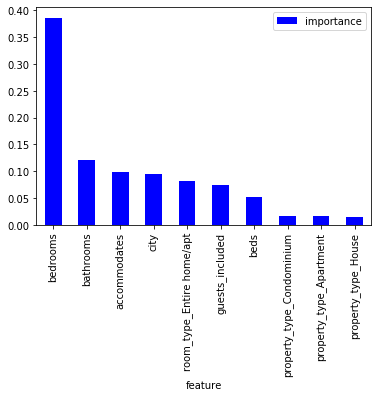

In [52]:
#list the training columns
train_cols = X.columns
#check importance of features
importances = clf.feature_importances_
feat_names = train_cols
#Obtain importance in model prediction of each feature in the listed training columns
tree_result = pd.DataFrame({'feature': feat_names, 'importance': importances})
#sort the importance by score, highest importance to lowest and plot it as a bar chart
tree_result.sort_values(by='importance',ascending=False)[:10].plot(x='feature', y='importance', kind='bar',color='blue')